### Evaluate the sensitivity of the water mass transformation calculation, and budget closure, to different parameter choices

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
import budgetcalcs as bc
import calc_wmt as wmt

In [2]:
rootdir = '/archive/gam/MOM6-examples/ice_ocean_SIS2/Baltic_OM4_025/1yr/'
averaging = '5daily'
vgrid = 'native'
filename = '19000101.ocean_'+averaging+'_'+vgrid+'_19*.nc'
filename_grid = '19000101.ocean_static.nc'
ds = xr.open_mfdataset(rootdir+filename, combine='by_coords')
delta_t = ds['average_DT'].astype('timedelta64[s]')
grid = xr.open_dataset(rootdir+filename_grid)

cp = 3992.0
rho0 = 1035.0

if vgrid == 'z':
    ds = ds.rename({'z_l':'zl'})

In [3]:
# Budget terms
heat_terms = ['opottemptend','T_advection_xy','Th_tendency_vert_remap',
              'boundary_forcing_heat_tendency','internal_heat_heat_tendency',
              'opottempdiff','opottemppmdiff','frazil_heat_tendency']
salt_terms = ['osalttend','S_advection_xy','Sh_tendency_vert_remap',
              'boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
h_terms = ['dhdt','dynamics_h_tendency','vert_remap_h_tendency',
           'boundary_forcing_h_tendency','internal_heat_h_tendency']

In [4]:
# Calculate material derivative and diffusive terms
# HEAT
signsLHS = [-1,1,1]
signsRHS = [1,1,1,1,1]
termsLHS = heat_terms[:3]
termsRHS = heat_terms[3:]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)
# SALT
signsLHS = [-1,1,1]
signsRHS = [1,1,1]
termsLHS = salt_terms[:3]
termsRHS = salt_terms[3:]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,plot=False)

In [5]:
# Time-mean : for evaluating dia-boundary transport and integrated process tendencies
l = ds['temp'] # Time-mean volume-defining tracer
l_name = l.name+'_bin' # Naming of binning variable as will be defined by xhistogram
# dl = dsalt
dl = dheat/cp/rho0 # Sum of diffusive tendencies for volume-defining tracer
h = ds['thkcello']

# Grid dimensions
area = grid.areacello # Grid dimensions

# Time-mean tendencies of budget tracer due to different processes
f = ds['boundary_forcing_h_tendency'] # Boundary forcing

In [6]:
fromsnap = False
filename_snap = '19000101.ocean_'+averaging+'_'+vgrid+'_snap*.nc'
ds_snap = xr.open_mfdataset(rootdir+filename_snap, combine='by_coords')

# Snapshots: for evaluating budget tracer content tendency
# NOTE: time-mean i corresponds to the snapshots at i and i-1
# so, for example, diff(snap[1]-snap[0])/dt = mean[1]
l_snap = ds_snap['temp'] # Snapshots of volume-defining tracer
h_snap = ds_snap['thkcello'] # Snapshots of layer thickness (for tracer content calculation)

In [7]:
# if vgrid == 'z':
#     ds_snap = ds_snap.rename({'z_l':'zl'})

In [8]:
# Binning variables
delta_l = 0.25
l_i_vals = np.arange(-4,34,delta_l)
# delta_l = 0.01
# l_i_vals = np.arange(2,36,delta_l)

# Calculation of G : budget tracer tendency due to dia-boundary mass transport 
G = wmt.calc_G(l,dl,l_i_vals,area,plot=False)
# Calculation of P^n : volume integrated budget tracer tendencies
F = wmt.calc_P(f,l,l_i_vals,area)

if fromsnap == False:
    # Calculation of volume tendency
    V = wmt.calc_P(h,l,l_i_vals,area)
    dV = V.diff('time')

    # Take average G over two timesteps
    Gdt = 0.5*((G*delta_t.astype('float')).rolling(time=2,center=True).sum()[1:,:])
    Fdt = 0.5*((F*delta_t.astype('float')).rolling(time=2,center=True).sum()[1:,:])
    
elif fromsnap == True:
    V = wmt.calc_P(h_snap,l_snap,l_i_vals,area)
    dV = V.diff('time')
    
    Gdt = (G*delta_t.astype('float'))[1:,:]
    Fdt = (F*delta_t.astype('float'))[1:,:]
    
    dV = dV.assign_coords({'time':Gdt['time']})

# Residual
residual = dV-Gdt-Fdt

In [9]:
dV.load();
Gdt.load();
Fdt.load();
residual.load();

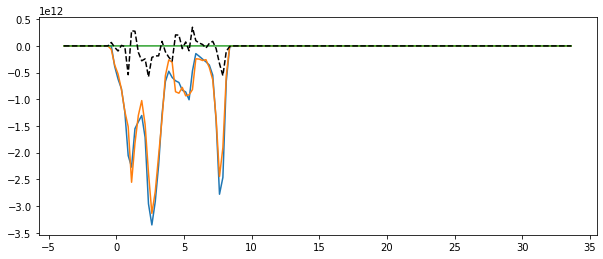

In [10]:
# One timestep
t=0
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(dV[l_name],dV.isel(time=t))
ax.plot(Gdt[l_name],Gdt.isel(time=t))
ax.plot(Fdt[l_name],Fdt.isel(time=t))
ax.plot(residual[l_name],residual.isel(time=t),'k--')

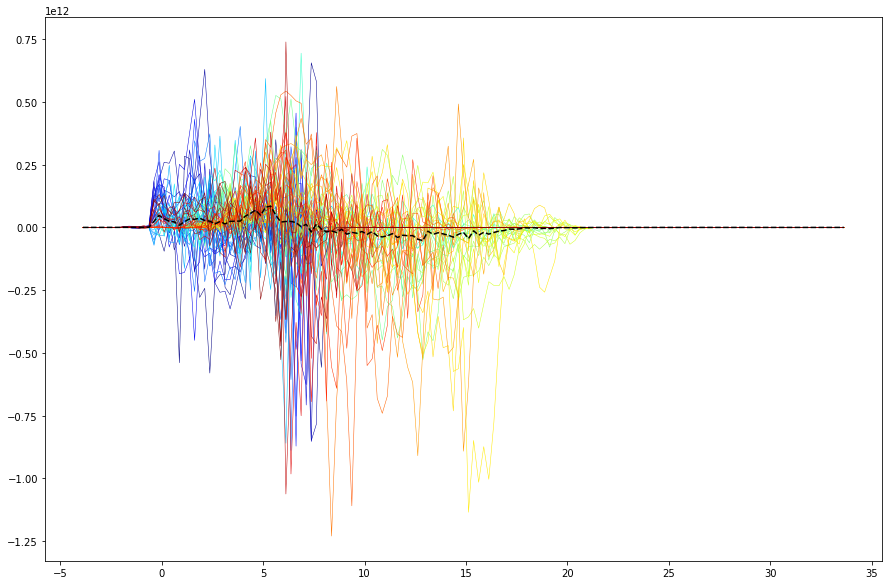

In [11]:
# Every timestep
nt = len(dV['time'])
colors = plt.cm.jet(np.linspace(0,1,nt))
fig,ax = plt.subplots(figsize=(15,10))
for t in range(nt):
    ax.plot(residual[l_name],residual.isel(time=t),color=colors[t],linewidth=0.5)
ax.plot(residual[l_name],residual.mean('time'),'k--')

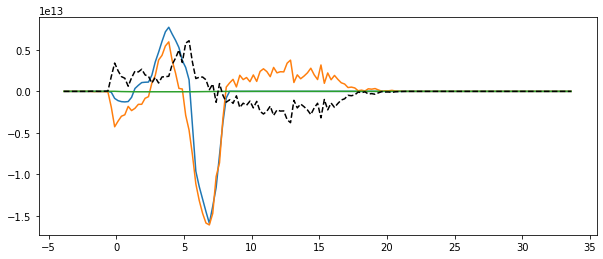

In [12]:
# Annual integral
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(dV[l_name],dV.sum('time'))
ax.plot(Gdt[l_name],Gdt.sum('time'))
ax.plot(Fdt[l_name],Fdt.sum('time'))
ax.plot(residual[l_name],residual.sum('time'),'k--')

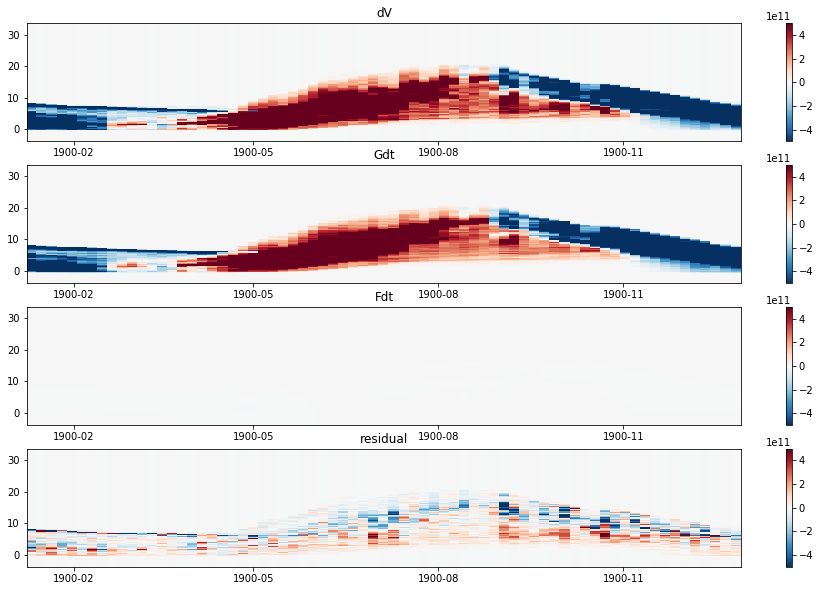

In [13]:
# All data
fig,(ax0,ax1,ax2,ax3) = plt.subplots(figsize=(16,10),nrows=4)
vmin=-0.5E12
vmax=0.5E12
im=ax0.pcolormesh(dV['time'],dV[l_name],dV.transpose(),cmap='RdBu_r',vmin=vmin,vmax=vmax);
ax0.set_title('dV')
plt.colorbar(im,ax=ax0)
im=ax1.pcolormesh(Gdt['time'],Gdt[l_name],Gdt.transpose(),cmap='RdBu_r',vmin=vmin,vmax=vmax);
ax1.set_title('Gdt')
plt.colorbar(im,ax=ax1)
im=ax2.pcolormesh(Fdt['time'],Fdt[l_name],Fdt.transpose(),cmap='RdBu_r',vmin=vmin,vmax=vmax);
ax2.set_title('Fdt')
plt.colorbar(im,ax=ax2)
im=ax3.pcolormesh(residual['time'],residual[l_name],residual.transpose(),cmap='RdBu_r',vmin=vmin,vmax=vmax);
ax3.set_title('residual')
plt.colorbar(im,ax=ax3)

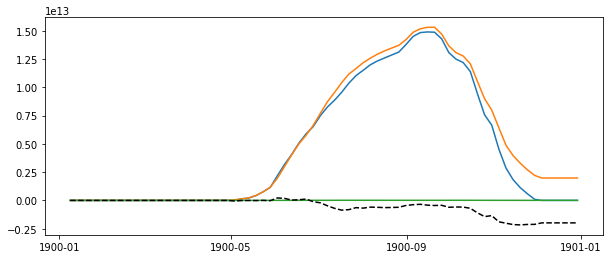

In [14]:
# One temperature layer, cumulative
T = 10
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(dV['time'],dV.sel({l_name:T},method='nearest').cumsum('time'))
ax.plot(Gdt['time'],Gdt.sel({l_name:T},method='nearest').cumsum('time'))
ax.plot(Fdt['time'],Fdt.sel({l_name:T},method='nearest').cumsum('time'))
ax.plot(residual['time'],residual.sel({l_name:T},method='nearest').cumsum('time'),'k--')

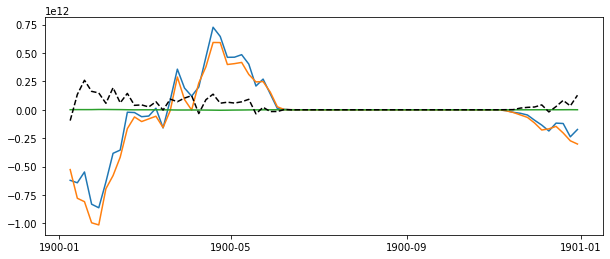

In [70]:
# One temperature layer
T = 0
fig,ax = plt.subplots(figsize=(10,4))
ax.plot(dV['time'],dV.sel({l_name:T},method='nearest'))
ax.plot(Gdt['time'],Gdt.sel({l_name:T},method='nearest'))
ax.plot(Fdt['time'],Fdt.sel({l_name:T},method='nearest'))
ax.plot(residual['time'],residual.sel({l_name:T},method='nearest'),'k--')

In [52]:
def calc_refine(da,refineby,variable_type,vertc='zl'):
    nk = len(da[vertc])
    # Set vertical coordinate to layer index
    da=da.assign_coords({vertc:np.linspace(1,nk,nk)})
    # Assign a k-value for the interfaces
    k_i = np.linspace(0.5,nk+0.5,nk+1)
    # Develop the super grid, based on the interfaces
    k_i_target = np.linspace(0.5,nk+0.5,nk*refineby+1)
    # Get the value of the layers on the super grid
    k_l_target = 0.5*(k_i_target[1:]+k_i_target[:-1])
    
    # Refine the grid
    if variable_type == 'intensive':
        da_refined = da.interp({vertc:k_l_target},method='linear',kwargs={'fill_value':'extrapolate'})
    if variable_type == 'extensive':
        da_refined = xr.zeros_like(da.interp({vertc:k_l_target}))
        for k in range(nk):
            index = np.arange(k*refineby,(k+1)*refineby)
            vertc_ones = xr.DataArray(np.ones(shape=(refineby)),dims=[vertc],coords={vertc:k_l_target[index]})
            chunk = (da.isel({vertc:k})/refineby)*vertc_ones
            # Input array must have same dimensional order as indexed array
            ### THERE MUST BE A MORE EFFICIENT WAY TO DO THIS ###
            if len(da.dims)==1:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk
            elif len(da.dims)==2:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1])
            elif len(da.dims)==3:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2])
            elif len(da.dims)==4:
                da_refined.loc[{vertc:k_l_target[index]}]=chunk.transpose(list(da.dims)[0],list(da.dims)[1],list(da.dims)[2],list(da.dims)[3])
    return da_refined

/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


[560766.46407272]


/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less_equal
  return func(*args2)
/nbhome/gam/miniconda/envs/mom6-clean/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


512382.94401546894


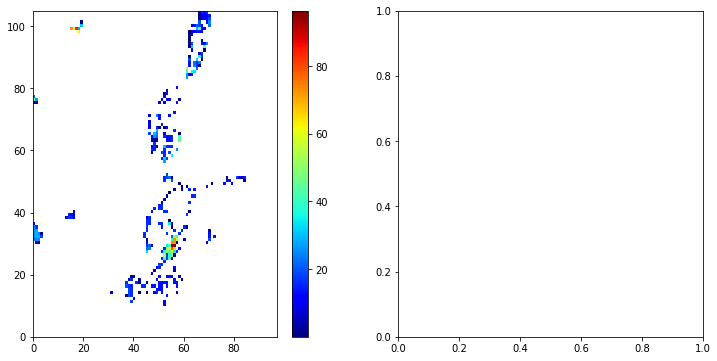

In [71]:
t = 40
T = 5
dT = 0.5

cmap = plt.cm.jet
cmap.set_bad(color='white')

h = ds['thkcello'].isel(time=t)
temp = ds['temp'].isel(time=t)
dl = (dheat.isel(time=t)/cp/rho0)*grid['areacello']

# dVdt
V_snap = (ds_snap['thkcello']*grid['areacello']).isel(time=slice(t-1,t+1))
temp_snap = ds_snap['temp'].isel(time=slice(t-1,t+1))
volume = (temp_snap>T)
dVdt = (V_snap.where(volume,0).sum(['xh','yh','zl'])).diff('time')/(5*86400)
print(dVdt.values)

fig,(ax1,ax2)=plt.subplots(figsize=(12,6),ncols=2)

layer=(temp>T-dT/2) & (temp<=T+dT/2)
h_layer=h.where(layer,0).sum('zl')
h_layer=h_layer.where(h_layer!=0,np.nan)
im=ax1.pcolormesh(h_layer,cmap=cmap)
plt.colorbar(im,ax=ax1)

dl_layer = dl.where(layer,0).sum(['xh','yh','zl'])/dT
print(dl_layer.values)

# refineby = 8
# temp_r = calc_refine(temp.load(), refineby=refineby, variable_type='intensive')
# h_r = calc_refine(h.load(), refineby=refineby, variable_type='extensive')
# dl_r = calc_refine(dl.load(), refineby=refineby, variable_type='extensive')

# layer=(temp_r>T-dT/2) & (temp_r<=T+dT/2)
# h_layer=h_r.where(layer,0).sum('zl')
# h_layer=h_layer.where(h_layer!=0,np.nan)
# im=ax2.pcolormesh(h_layer,cmap=cmap)
# plt.colorbar(im,ax=ax2)

# dl_layer = dl_r.where(layer,0).sum(['xh','yh','zl'])/dT
# print(dl_layer.values)